# Análise não-linear de séries temporais
Este tipo de análise consiste em um conjunto de metodologias que começaram a ser desenvolvidas na década de 1990 com a finalidade de estudar sistemas complexos. Uma [boa revisão](https://aip.scitation.org/doi/pdf/10.1063/1.4917289?casa_token=J6ENq2j7UZYAAAAA:zHvGR93etcwS0jZPxq1Gu3sw1xPcVefi89Qh3lepPIFxUm6zkQcdnGPXPVbR3Rvo9qg_LFdtlMzQ) deste assunto nos informa que se trata de buscar caracterizar o sistema dinâmico por trás do fenômeno estudado, frequentemente, um sistema caótico deterministico. O Artigo de [Basharat et al.](http://www.cs.ucf.edu/~arslan/Basharat_ICCV09.pdf) mostra uma aplicação muito útil desta metodologia.

In [1]:
import numpy as np
import scipy as sp
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score as MI
from scipy.integrate import odeint
from ipywidgets import interact, interactive, fixed
from IPython.display import clear_output, display
import ipywidgets as widgets
%matplotlib inline 
plt.rcParams['figure.figsize'] = (15.0, 10.0)

ModuleNotFoundError: No module named 'sklearn'

## Reconstrução do espaço de estados
A reconstrução do espaço de estados do sistema dinâmico é a pedra fundamental desta metodologia. Para isso normalmente usamos Retratos de fase $m$-dimensionais atrasados da nossa série $y(t)$:

$$\overrightarrow{R}(t)=\left[y(t), y(t-\tau), y(t-2\tau),\ldots,y(t-(m-1)\tau)\right]$$

Vamos explorar esta reconstrução com uma série simulada a partir das equações de Rössler.

\begin{align}
\frac{dx}{dt}&=-y-z\\
\frac{dy}{dt}&=x+a y\\
\frac{dz}{dt}&=b + z  (x - c)
\end{align}

In [2]:
def rossler(Y,t,*pars):
    x,y,z = Y
    a,b,c = pars
    return [
        -y-z,
        x+(a*y),
        b+z*(x-c)
    ]

In [3]:
inits = [4,4,5]
a,b,c = 0.2, 0.2, 5.7
trange = range(20000)
res = odeint(rossler,inits,trange, args=(a,b,c))

De acordo com o [teorema de Takens](https://math.stackexchange.com/questions/2262961/understanding-takens-embedding-theorem) sobre delay embedding, nos diz que podemos reconstruir um atrator estranho de dimensão $n$ a partir apenas de uma série temporal $x(t)$  de medidas do sistema dinâmico original usado para reconstruir o atrator em um espaço de fase atrasado de dimensão $m\leq n$: $y(t)=[y(t-\tau), y(t-2\tau),\ldots,y(t-(m-1)\tau)]$. 

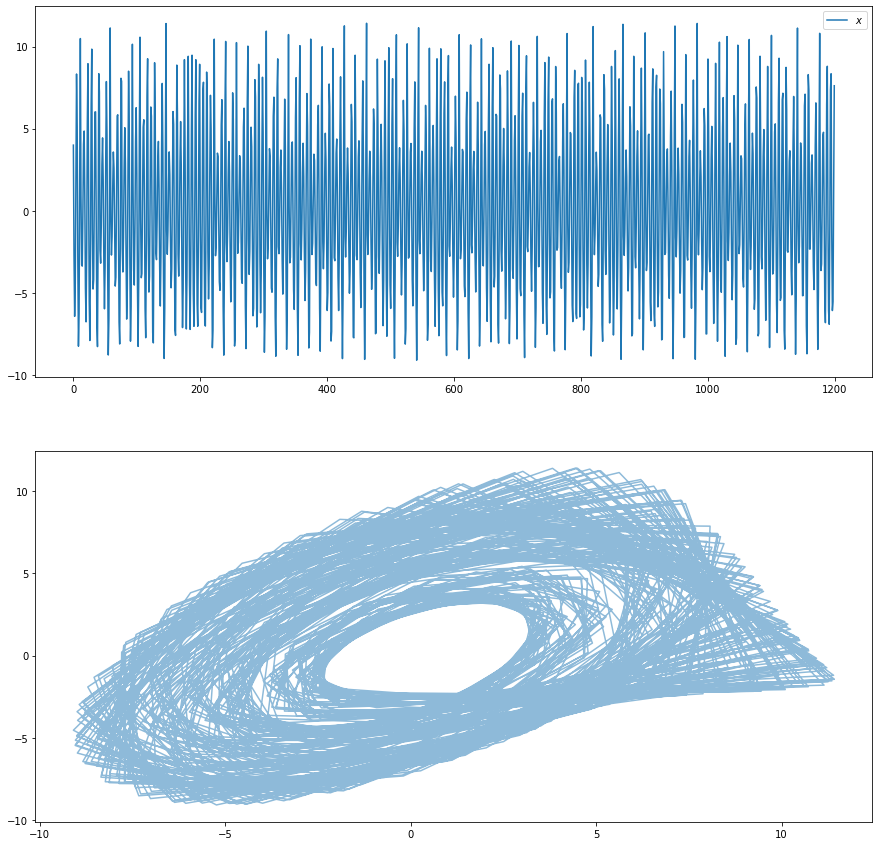

In [5]:
f,[ax1,ax2] = plt.subplots(2,1,figsize=(15,15))
ax1.plot(res[:1200,0], label='$x$');
ax1.legend()
ax2.plot(res[:1200,0],res[1:1201,0], alpha=.5);

A series atrasadas com valores de $\tau$ pequenos, tendem a ser muito correlacionadas. Portanto a escolha de $\tau$ é importante. Abaixo temos uma figura interativa que nos permite visualizar o atrator do sistema em 3 dimensões para vários valores de $\tau$. Uma das maneiras mais comuns de se estima o melhor valor de $\tau$ é através da [informação mútua](https://en.wikipedia.org/wiki/Mutual_information) entre as séries, queremos encontrar o menor valor de tau, que minimiza a informação mútua.

Para simplicidade de cálculo podemos obter a informação mútua a partir da correlação:
$$I=-\frac{1}{2}log(1-\rho^2)$$

Esta aproximação pressupõe que ambas as séries têm distribuição Gaussiana.

interactive(children=(IntSlider(value=7, description='tau', max=40), Output()), _dom_classes=('widget-interact…

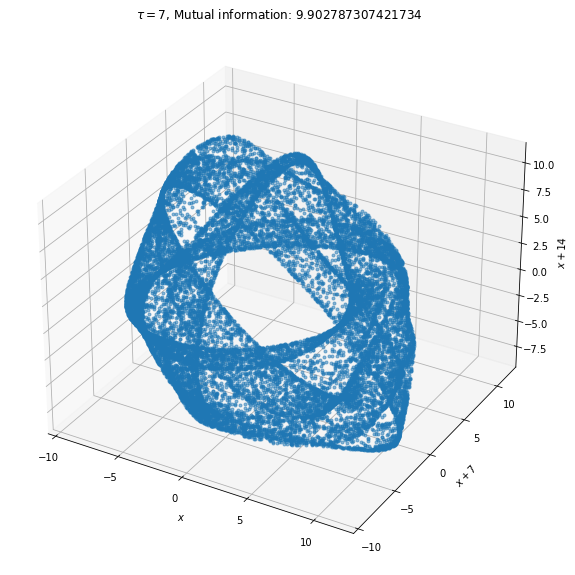

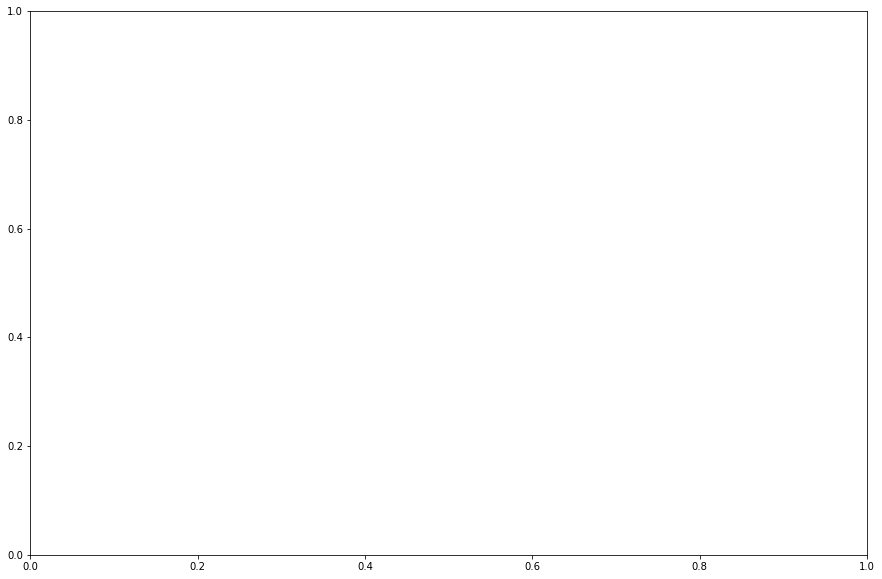

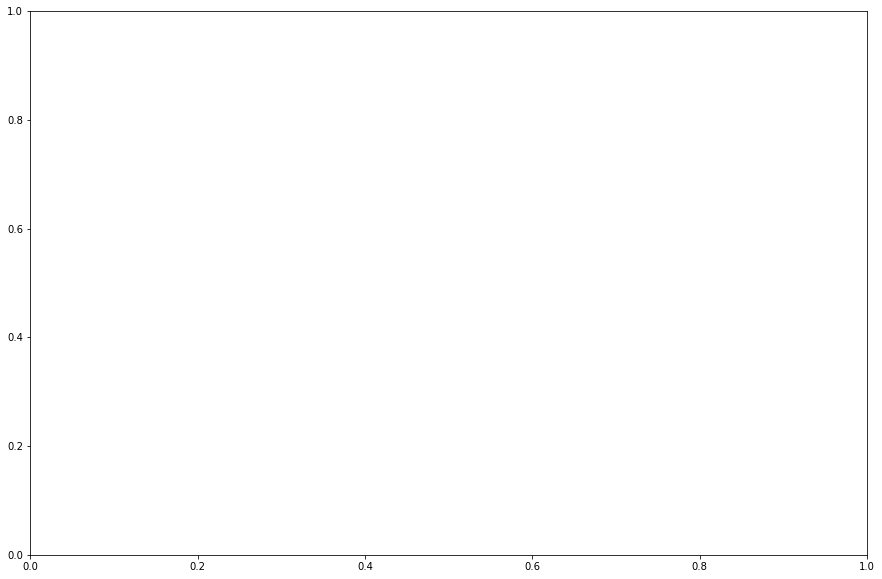

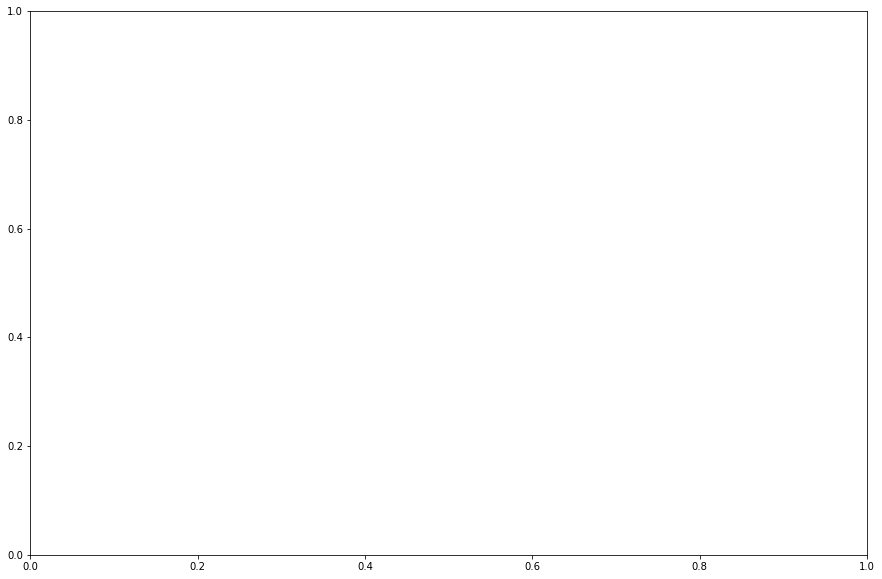

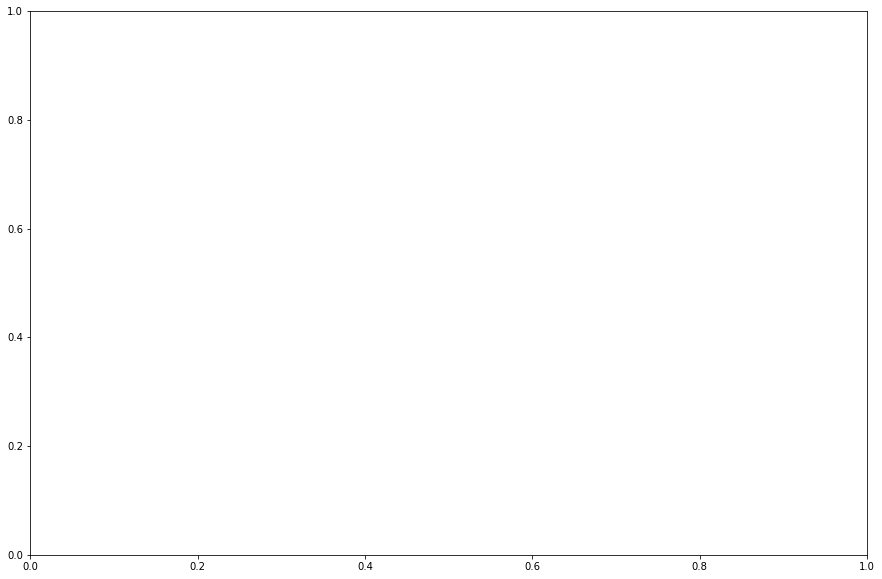

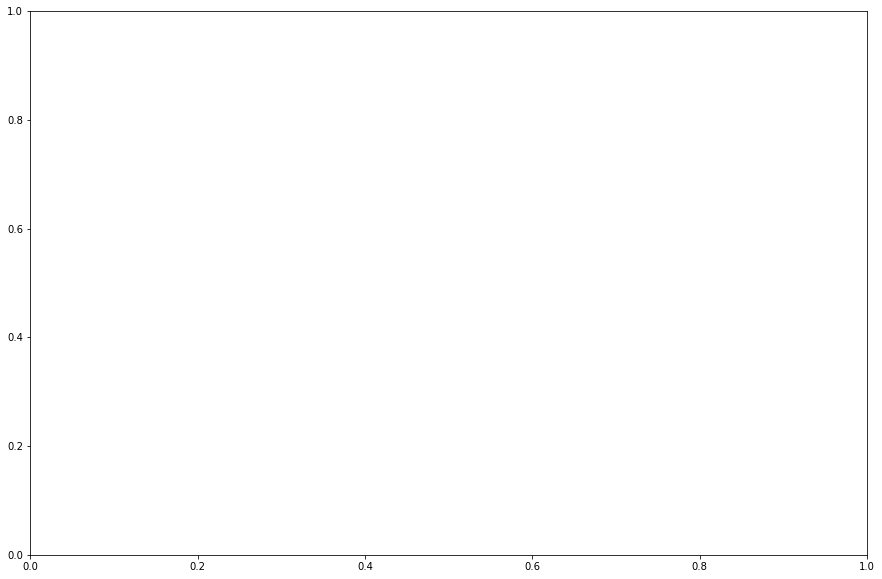

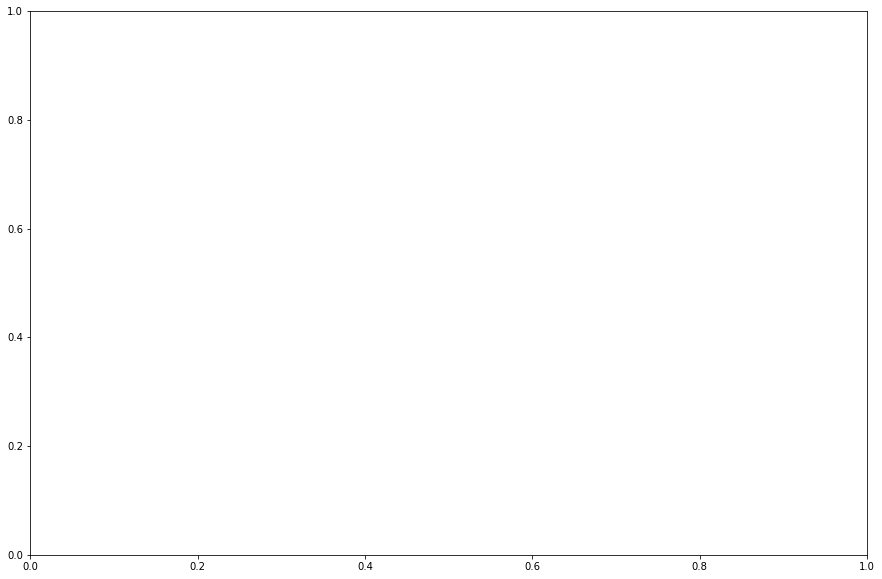

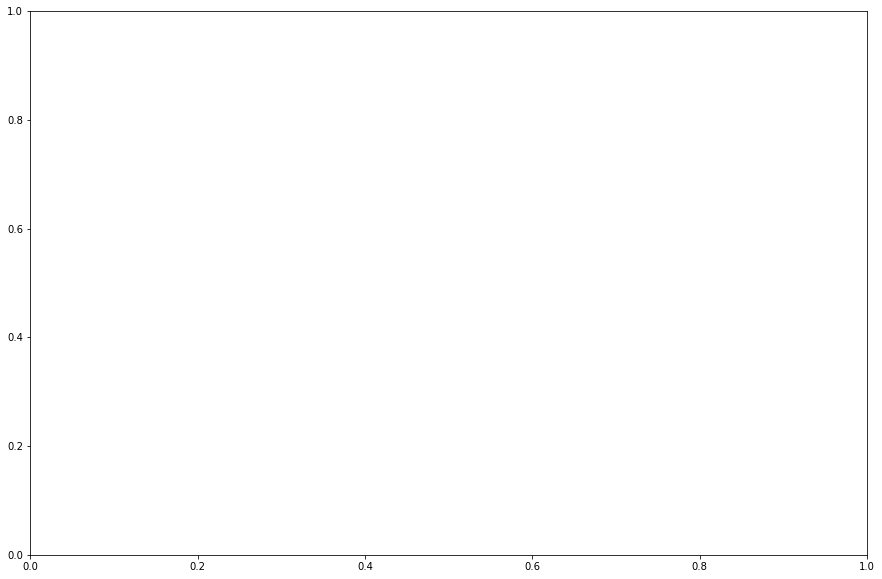

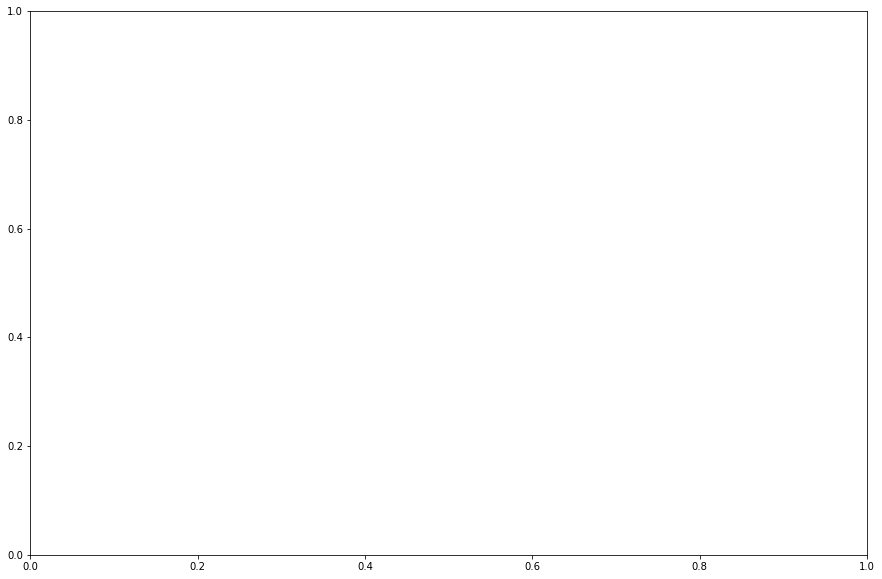

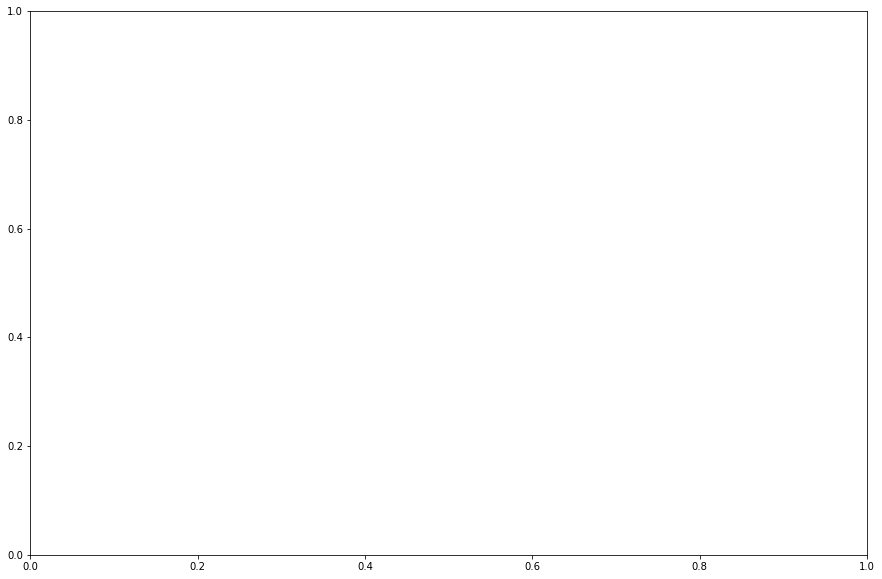

In [6]:
fig = plt.figure()
ax=fig.gca(projection='3d')
@interact(tau=widgets.IntSlider(7,0,40,1))
def embed(tau):
    plt.cla()
    x,y,z = res[:-2*tau,0],res[tau:-tau,0], res[2*tau:,0]
    mi = MI(x,y)
    ax.plot(x,y,z, '.', alpha=0.5)
    ax.set_title(fr'$\tau={tau}$, Mutual information: {mi}')
    ax.set_xlabel(f'$x$')
    ax.set_ylabel(f'$x+{tau}$')
    ax.set_zlabel(f'$x+{2*tau}$')

    clear_output(wait=True)
    

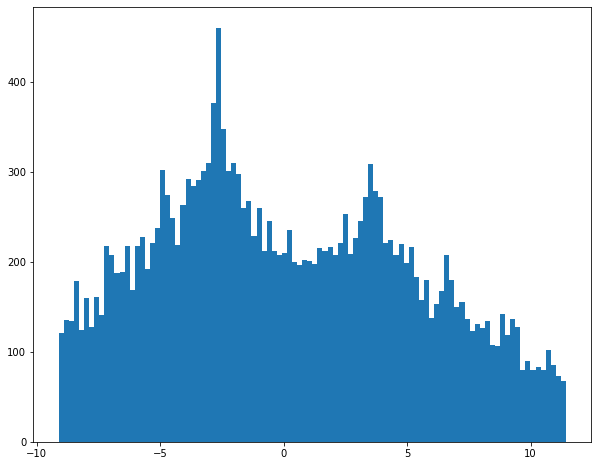

In [25]:
# Verificando a distibuição da série.
f,ax = plt.subplots(1,1,figsize=(10,8))
ax.hist(res[:,0],bins=100);

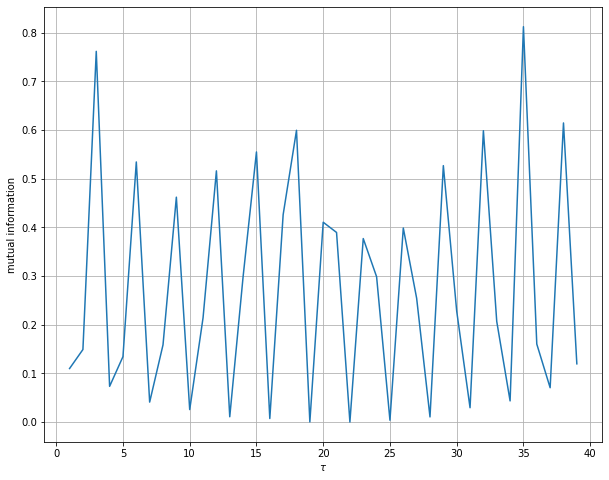

In [26]:
mis = []
for tau in range(1,40):
    mis.append(-0.5*np.log(1-pearsonr(res[:-tau,0],res[tau:,0])[0]**2))
#     mis.append(MI(res[:-tau,0],res[tau:,0]))
f,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(range(1,40),mis)
ax.grid()
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'mutual information');

## Estimando $m$, a dimensão de embedding
Para esta parte vamos nos utilizar da biblioteca [nolds](https://github.com/CSchoel/nolds): Non-linear measures for Dynamical Systems. Nela temos a implementação do algoritmo  de Grassberger-Procaccia para cálculo da dimensão de correlação. Também vamos usar a biblioteca [Neurokit2](https://neurokit2.readthedocs.io) para estimação de dimensão de embedding.

In [27]:
import nolds
import neurokit2 as nk

In [28]:
nolds.corr_dim(res[:,0],4)

1.7979750803415464

{'delay': 4, 'dimension': 4, 'r': 0.6193779146523386}

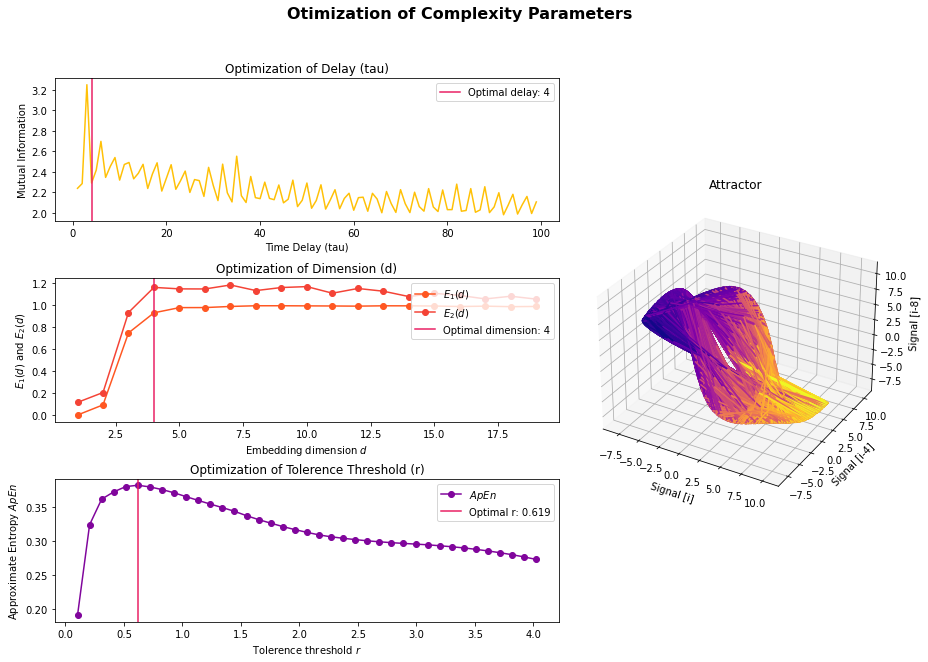

In [29]:
parameters = nk.complexity_optimize(res[:,0], show=True)
parameters

## Fazendo previsões a partir do sinal reconstruído.
Para testar a utilidade da reconstrução realizada, vamos utilizar uma regressão usando Kernel regression e também Lightgbm.

In [7]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error
from statsmodels.nonparametric.kernel_regression import KernelReg

In [10]:
data = pd.DataFrame(data={'ts':res[:,0]})
tau = 4
data['lag1'] = data.ts.shift(1*tau)
data['lag2'] = data.ts.shift(2*tau)
data['lag3'] = data.ts.shift(3*tau)
data['lag4'] = data.ts.shift(4*tau)
data

,ts,lag1,lag2,lag3,lag4
0,4.000000,NaN,NaN,NaN,NaN
1,-2.701291,NaN,NaN,NaN,NaN
2,-6.424261,NaN,NaN,NaN,NaN
3,-4.422475,NaN,NaN,NaN,NaN
4,2.517592,4.000000,NaN,NaN,NaN
...,...,...,...,...,...
19995,-2.921642,-4.679059,7.140714,-3.954312,-5.143011
19996,-1.382961,5.279095,2.531852,-5.201302,3.361338
19997,1.899994,11.153827,-4.979770,-1.427417,10.091506
19998,3.954745,-1.584968,-8.944661,4.618631,1.552838


Agora vamos remover as primeiras linhas que contém `NaN`s

In [11]:
data = data.dropna()
data

,ts,lag1,lag2,lag3,lag4
16,4.044545,0.925383,-8.239929,2.517592,4.000000
17,4.859027,-3.280940,-6.255662,8.328219,-2.701291
18,0.920742,-3.366459,2.529070,5.158565,-6.424261
19,-4.702702,-0.042813,10.486560,-2.988373,-4.422475
20,-6.760360,4.044545,0.925383,-8.239929,2.517592
...,...,...,...,...,...
19995,-2.921642,-4.679059,7.140714,-3.954312,-5.143011
19996,-1.382961,5.279095,2.531852,-5.201302,3.361338
19997,1.899994,11.153827,-4.979770,-1.427417,10.091506
19998,3.954745,-1.584968,-8.944661,4.618631,1.552838


### Kernel regression
Vamos usar a biblioteca statsmodels para ajustar a [regressão de kernel](https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.kernel_regression.KernelReg.html#statsmodels.nonparametric.kernel_regression.KernelReg) não paramétrica. Para economizar tempo, vamos ajustar a regressão por Kernel utilizando apenas os primeiros 500 pontos. So we will use only the first 500 points to fit the regression model.

In [34]:
model = KernelReg(data.ts[17:517], data[['lag1','lag2','lag3','lag4']][:500],var_type=['c','c','c','c'])

Agora vamos usar os 500 pontos seguintes para testar o poder preditivo do modelo.

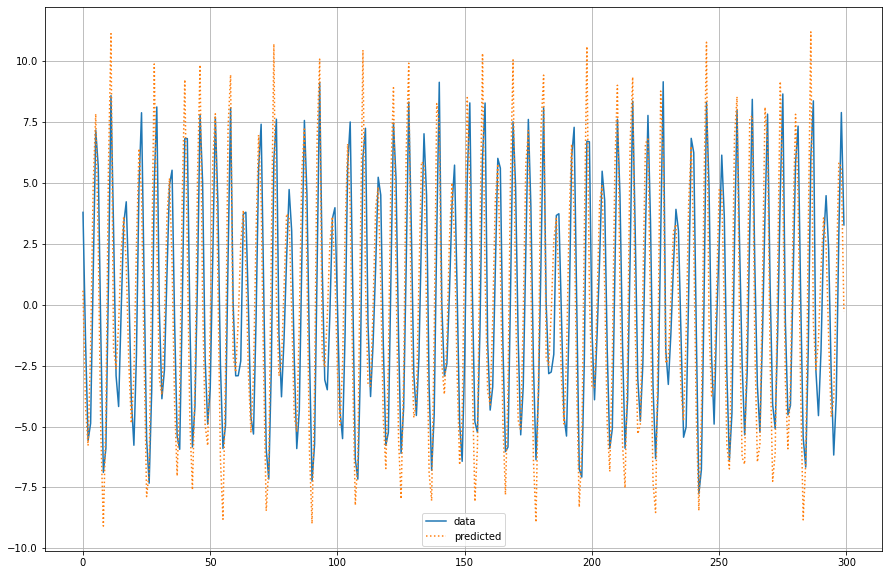

In [35]:
m,marg = model.fit(data_predict=data[['lag1','lag2','lag3','lag4']][517:817])
plt.plot(m, label='data')
plt.plot(range(300),data.ts[517:817],':',label='predicted')
plt.grid()
plt.legend();

In [37]:
model.r_squared()

0.930493588694165

### LightGBM regression

In [8]:
from flaml import AutoML
automl = AutoML()

In [14]:
train_size = 1000
dftrain = data[['lag1','lag2','lag3','lag4']][:train_size]
dftest = data[['lag1','lag2','lag3','lag4']][train_size+17:train_size+17+300]
Y = data.ts[17:train_size+17]

In [15]:
X_train, X_test, y_train, y_test = train_test_split( dftrain, Y, test_size=0.2, random_state=42)

In [21]:
automl_settings = {
    "time_budget": 10,  # in seconds
    "metric": 'r2',
    "task": 'regression',
    "log_file_name": "reg.log",
    #"estimator_list": ["lgbm"]
}
automl.fit(X_train, y_train, **automl_settings)

[flaml.automl: 06-29 10:35:54] {908} INFO - Evaluation method: cv
[flaml.automl: 06-29 10:35:54] {617} INFO - Using RepeatedKFold
[flaml.automl: 06-29 10:35:54] {929} INFO - Minimizing error metric: 1-r2
[flaml.automl: 06-29 10:35:54] {948} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree']
[flaml.automl: 06-29 10:35:54] {1012} INFO - iteration 0, current learner lgbm
[flaml.automl: 06-29 10:35:58] {1159} INFO -  at 3.9s,	best lgbm's error=0.5709,	best lgbm's error=0.5709
[flaml.automl: 06-29 10:35:58] {1012} INFO - iteration 1, current learner lgbm
[flaml.automl: 06-29 10:36:00] {1159} INFO -  at 5.5s,	best lgbm's error=0.5709,	best lgbm's error=0.5709
[flaml.automl: 06-29 10:36:00] {1012} INFO - iteration 2, current learner lgbm
[flaml.automl: 06-29 10:36:02] {1159} INFO -  at 7.9s,	best lgbm's error=0.5709,	best lgbm's error=0.5709
[flaml.automl: 06-29 10:36:02] {1012} INFO - iteration 3, current learner xgboost
[flaml.automl: 06-29 10:36:0

In [22]:
''' retrieve best config'''
print('Best hyperparmeter config:', automl.best_config)
print('Best r2 on validation data: {0:.4g}'.format(1-automl.best_loss))

Best hyperparmeter config: {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}
Best r2 on validation data: 0.431


In [56]:
y_pred = automl.predict(dftest)

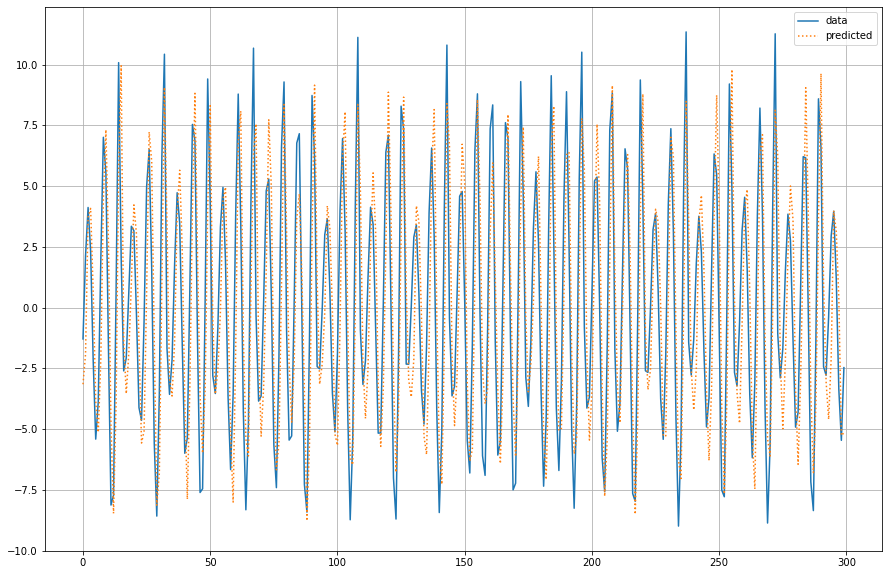

In [57]:
test_size = len(dftest)
plt.plot(range(300),data.ts[train_size+17:train_size+17+300], label='data')
plt.plot(y_pred,':',label='predicted')
plt.grid()
plt.legend();